In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import pandas_datareader.data as web
import seaborn as sns
from sklearn import linear_model
from sklearn import preprocessing;
from sklearn.model_selection import cross_validate as cross_validation
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# %matplotlib inline

In [2]:
import datetime
from datetime import timedelta
forecast_out = 365 #Days from now

stock_ticker ='BBCA.JK'
stock_parameter ='Daily gain'
epoch_number=50
epoch_number_forecast=50

end = datetime.datetime.now()#-timedelta(7) #remove timedetla -1 to go to productions mode
start = datetime.datetime.now()-timedelta(forecast_out)

# benchmark = web.DataReader(stock_ticker, 'yahoo', start, end )
stock = web.DataReader(stock_ticker, 'yahoo', start, end)
stock['Daily gain']=stock['Adj Close'].pct_change(1)
stock=stock.dropna(axis=0)
stock

,High,Low,Open,Close,Volume,Adj Close,Daily gain
Date,,,,,,,
2019-05-07,28550.0,28250.0,28375.0,28300.0,11835400.0,27731.326172,0.007117
2019-05-08,28500.0,27975.0,28000.0,28500.0,11812400.0,27927.308594,0.007067
2019-05-09,28500.0,28125.0,28500.0,28150.0,25327300.0,27584.341797,-0.012281
2019-05-10,28400.0,28000.0,28050.0,28050.0,15226100.0,27486.351562,-0.003552
2019-05-13,28475.0,28000.0,28400.0,28050.0,12744100.0,27486.351562,0.000000
...,...,...,...,...,...,...,...
2020-04-27,25100.0,24275.0,24700.0,24800.0,30220700.0,24800.000000,0.008130
2020-04-28,24875.0,24025.0,24800.0,24150.0,36097600.0,24150.000000,-0.026210
2020-04-29,24250.0,24000.0,24125.0,24250.0,24232200.0,24250.000000,0.004141


In [3]:
test_size=20
test_index = len(stock[stock_parameter])- test_size

In [4]:
train = stock[stock_parameter].iloc[:test_index]
test= stock[stock_parameter].iloc[test_index:]

In [5]:
from sklearn.preprocessing import MinMaxScaler

In [6]:
scaler=MinMaxScaler()
scaler.fit(train.to_frame())
scaled_train = scaler.transform(train.to_frame())
scaled_test = scaler.transform(test.to_frame())

In [7]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [8]:
length=test_size-1
generator = TimeseriesGenerator(scaled_train,scaled_train, length=length, batch_size=1)

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

In [10]:
n_features =1
model= Sequential()
# pretty good model at 200 epochs
# model.add(LSTM(50, activation='relu', input_shape=(length, n_features)))
# model.add(Dropout(0.2))
# model.add(Dense(25, activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(10, activation='relu'))
# model.add(Dropout(0.2))

model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dropout(0.2))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(15, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='SGD', loss='mse')

In [11]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=1)

In [12]:
validation_generator= TimeseriesGenerator(scaled_test, scaled_test,
                                          length=length, batch_size =1)

In [13]:
# model.fit_generator(generator, epochs=20,
#                    validation_data=validation_generator, callbacks=[early_stop])
model.fit_generator(generator, epochs=epoch_number,
                   validation_data=validation_generator)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 214 steps, validate for 1 steps
Epoch 1/50
214/214 [==============================] - 5s 24ms/step - loss: 0.0143 - val_loss: 0.0023
Epoch 2/50
214/214 [==============================] - 2s 11ms/step - loss: 0.0071 - val_loss: 0.0020
Epoch 3/50
214/214 [==============================] - 2s 11ms/step - loss: 0.0066 - val_loss: 0.0012
Epoch 4/50
214/214 [==============================] - 2s 11ms/step - loss: 0.0061 - val_loss: 0.0047
Epoch 5/50
214/214 [==============================] - 2s 10ms/step - loss: 0.0059 - val_loss: 0.0025
Epoch 6/50
214/214 [==============================] - 2s 10ms/step - loss: 0.0060 - val_loss: 5.0230e-04
Epoch 7/50
214/214 [==============================] - 2s 9ms/step - loss: 0.0061 - val_loss: 0.0011
Epoch 8/50
214/214 [==============================] - 2s 9ms/step - loss: 0.0061 - val_loss: 0.0012
Epoch 9/50
214/214 [==

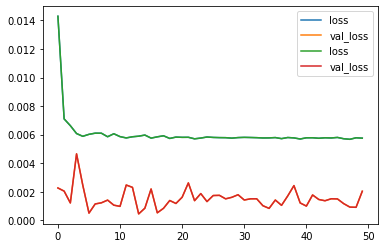

In [14]:
losses= pd.DataFrame(model.history.history)
ax =losses.plot()
losses.plot(ax=ax)
plt.savefig(stock_ticker+'_'+stock_parameter+'loss_chart.png')

In [15]:
test_predictions =[]
first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))
for i in range(len(test)):
    current_pred = model.predict(current_batch)[0]
    test_predictions.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]], axis=1)

In [16]:
true_predictions =scaler.inverse_transform(test_predictions)


In [17]:
predictions = pd.DataFrame(test)
predictions['Predictions'] = true_predictions

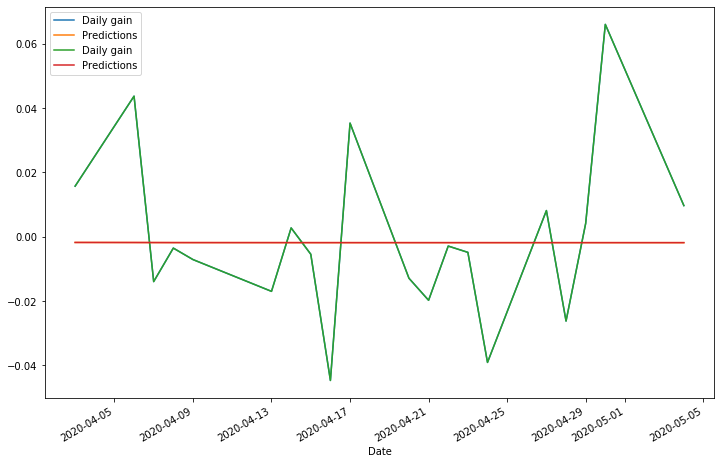

In [18]:
ax=predictions.plot(figsize=(12,8))
predictions.plot(ax=ax)
plt.savefig(stock_ticker+'_'+stock_parameter+'_predictions_chart.png')

In [19]:
from keras.models import load_model
model.save(stock_ticker+'_'+stock_parameter+'prediction'+'.h5')

Using TensorFlow backend.


# Forecasting

In [20]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(stock[stock_parameter].to_frame())

In [21]:
length=19
generator=TimeseriesGenerator(scaled_full_data, scaled_full_data, length=length, batch_size=1)

In [22]:
forecast_model= Sequential()
forecast_model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
forecast_model.add(Dropout(0.2))
forecast_model.add(Dense(50, activation='relu'))
forecast_model.add(Dropout(0.2))
forecast_model.add(Dense(15, activation='relu'))
forecast_model.add(Dropout(0.2))
forecast_model.add(Dense(1, activation='relu'))
forecast_model.compile(optimizer='SGD', loss='mse')
forecast_model.fit_generator(generator, epochs=epoch_number_forecast)

  ...
    to  
  ['...']
Train for 234 steps
Epoch 1/50
234/234 [==============================] - 6s 25ms/step - loss: 0.0127
Epoch 2/50
234/234 [==============================] - 3s 12ms/step - loss: 0.0077
Epoch 3/50
234/234 [==============================] - 3s 11ms/step - loss: 0.0071
Epoch 4/50
234/234 [==============================] - 2s 11ms/step - loss: 0.0073
Epoch 5/50
234/234 [==============================] - 2s 10ms/step - loss: 0.0071
Epoch 6/50
234/234 [==============================] - 3s 12ms/step - loss: 0.0066
Epoch 7/50
234/234 [==============================] - 3s 13ms/step - loss: 0.0065
Epoch 8/50
234/234 [==============================] - 3s 13ms/step - loss: 0.0066
Epoch 9/50
234/234 [==============================] - 3s 12ms/step - loss: 0.0065
Epoch 10/50
234/234 [==============================] - 3s 12ms/step - loss: 0.0066
Epoch 11/50
234/234 [==============================] - 3s 12ms/step - loss: 0.0062
Epoch 12/50
234/234 [==============================

In [23]:
from keras.models import load_model
model.save(stock_ticker+'_'+stock_parameter+'forecast'+'.h5')

In [24]:
forecast =[]

periods=19

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(periods):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    forecast.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [25]:
forecast = scaler.inverse_transform(forecast)

In [26]:
forecast

array([[-0.00172792],
       [-0.0017544 ],
       [-0.00178127],
       [-0.00180029],
       [-0.00181354],
       [-0.00182268],
       [-0.00182909],
       [-0.00183346],
       [-0.00183626],
       [-0.0018384 ],
       [-0.00183961],
       [-0.00184037],
       [-0.00184093],
       [-0.00184129],
       [-0.00184141],
       [-0.00184163],
       [-0.00184167],
       [-0.00184177],
       [-0.00184197]])

In [27]:
from datetime import date
forecast_index = pd.date_range(start=date.today(), periods = periods, freq="D")

In [28]:
forecast_df = pd.DataFrame(data = forecast, index=forecast_index, columns=['Forecast'])

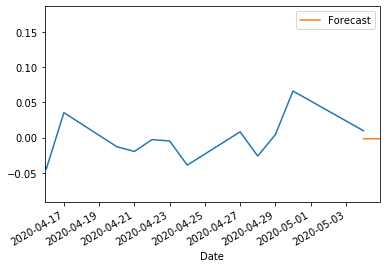

In [29]:
ax=stock[stock_parameter].plot()
forecast_df.plot(ax=ax)
plt.xlim( datetime.datetime.now()-timedelta(periods), datetime.datetime.now())
plt.savefig(stock_ticker+'_'+stock_parameter+'forecast_chart.png')


In [30]:
forecast_df.to_csv('forecast_'+stock_ticker+'_'+stock_parameter+'.csv')